In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

group_stage_table = pd.read_csv(r'CSVs\Group_Stage_Table.csv' , encoding ='latin-1')
world_cup_matches = pd.read_csv(r'CSVs\World_Cup_Matches.csv', encoding = 'latin-1')
world_cup_teams = pd.read_csv(r'CSVs\World_Cup_Teams.csv', encoding='latin-1')
squad_predictions = pd.read_csv(r'CSVs\Predictions\Predictions_8-19.csv', encoding ='latin-1')

import warnings
warnings.filterwarnings("ignore")

In [2]:
group_stage_matches = world_cup_matches[(world_cup_matches['Stage']=='Group')]

# Need to lookup Squad percentages from Squad_Predictions DF

group_stage_matches['S1%']=pd.merge(group_stage_matches, squad_predictions, how='left', left_on=['Squad 1'], right_on=['Squad'])['% of Points Taken']
group_stage_matches['S2%']=pd.merge(group_stage_matches, squad_predictions, how='left', left_on=['Squad 2'], right_on=['Squad'])['% of Points Taken']

# Calculate Probability of S1 winning based on Log 5 Formula

group_stage_matches['S1_Prob'] =((group_stage_matches['S1%'] - (group_stage_matches['S1%']*group_stage_matches['S2%'])) / (group_stage_matches['S1%'] + group_stage_matches['S2%'] - (2 * group_stage_matches['S1%'] * group_stage_matches['S2%'])))

In [ ]:
group_stage_matches.head(10)

In [32]:
np.random.seed(42)
num_sims = 1000

match_sims = []

for index,row in group_stage_matches.iterrows():
    result = np.random.binomial(n=1, p = row.S1_Prob, size=num_sims)
    match_sims.append(result)

len(match_sims)

48

In [33]:
group_results = []
for index, row in squad_predictions.iterrows():
    team = row.Squad
    group = row.Group
    team_percent = row["% of Points Taken"]
    
    team_rows = group_stage_matches.loc[(group_stage_matches['Squad 1'] == team)| (group_stage_matches['Squad 2']==team),['Squad 1','Squad 2', 'Group']]
    team_rows['is_squad_1'] = team_rows['Squad 1'] == team
    team_sims = [match_sims[i] for i in team_rows.index.to_list()]
    
    team_wins = []
    for x in range(len(team_rows)):
        is_squad_1 = team_rows.is_squad_1.values[x]
        game_wins = [y if is_squad_1 else int(not y) for y in team_sims[x]]
        team_wins.append(game_wins)
        
    team_results = np.sum(team_wins, axis=0)
    # Probably don't bring back team_wins once number of simulations go up
    
    group_results.append({'team':team, 'group':group, 'team_percent':team_percent, 'wins':team_results, 'points':team_results*3}) #, 'team_wins':team_wins})
    

2.5


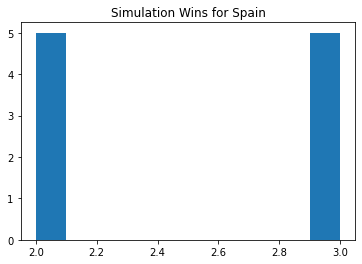

In [5]:
data = group_results[24]
print(np.mean(data['wins']))
plt.hist(data['wins'])
plt.title(f"Simulation Wins for {data['team']}")
plt.show()

In [6]:
r_16_matches = world_cup_matches[(world_cup_matches['Group']=='R16')]
r_16_matches

,Match,Squad 1,Squad 1 Key,Squad 2,Squad 2 Key,Group,Stage
48,49,1A,Knockout Round,2B,Knockout Round,R16,Knockout
49,50,1C,Knockout Round,2D,Knockout Round,R16,Knockout
50,51,1D,Knockout Round,2C,Knockout Round,R16,Knockout
51,52,1B,Knockout Round,2A,Knockout Round,R16,Knockout
52,53,1E,Knockout Round,2F,Knockout Round,R16,Knockout
53,54,1G,Knockout Round,2H,Knockout Round,R16,Knockout
54,55,1F,Knockout Round,2E,Knockout Round,R16,Knockout
55,56,1H,Knockout Round,2G,Knockout Round,R16,Knockout


In [14]:
r_8_matches = world_cup_matches[(world_cup_matches['Group']=='R8')]

In [20]:
r_4_matches = world_cup_matches[(world_cup_matches['Group']=='Semi-Finals')]

In [24]:
final_matches = world_cup_matches[(world_cup_matches['Group']=='Finals')]

In [25]:
final_matches

,Match,Squad 1,Squad 1 Key,Squad 2,Squad 2 Key,Group,Stage
62,63,M61,Knockout Round,M62,Knockout Round,Finals,Knockout


In [21]:
r_4_matches

,Match,Squad 1,Squad 1 Key,Squad 2,Squad 2 Key,Group,Stage
60,61,M57,Knockout Round,M58,Knockout Round,Semi-Finals,Knockout
61,62,M59,Knockout Round,M60,Knockout Round,Semi-Finals,Knockout


In [51]:
knockout_sims = []
r_8_sims = []
r_4_sims = []
finals_sims = []

for z in range(num_sims):
    if z % 50 == 0:
        print(z)
    lol_1 = [{'team':x['team'], 'group':x['group'], 'team_percent':x['team_percent'], 'wins':x['wins'][z], 'points':x['points'][z]} for x in group_results] 
    lol_1 = pd.DataFrame(lol_1)
    lol_1 = lol_1.sort_values(by=['group','points', 'team_percent'], ascending=[True,False,False]).reset_index(drop=True)
    lol_1['rank'] = (lol_1.index % 4) + 1
    lol_1['rank'] = lol_1['rank'].astype(str)
    lol_1['seed'] = lol_1['rank'] + lol_1['group']
    
    r_16_1 = pd.merge(r_16_matches, lol_1.loc[:,['team','team_percent','seed']], left_on='Squad 1', right_on='seed')
    r_16_1.drop(['Squad 1'], axis=1, inplace=True)
    r_16_1.rename(columns={'team':'Squad 1','team_percent':'S1%', 'seed':'Squad 1 Seed'}, inplace=True)

    r_16_1 = pd.merge(r_16_1, lol_1.loc[:,['team','team_percent','seed']], left_on='Squad 2', right_on='seed')
    r_16_1.drop(['Squad 2'], axis=1, inplace=True)
    r_16_1.rename(columns={'team':'Squad 2','team_percent':'S2%', 'seed':'Squad 2 Seed'}, inplace=True)

    r_16_1['S1_Prob'] =((r_16_1['S1%'] - (r_16_1['S1%']*r_16_1['S2%'])) / (r_16_1['S1%'] + r_16_1['S2%'] - (2 * r_16_1['S1%'] * r_16_1['S2%'])))

    r_16_1['S1_wins'] = [np.random.binomial(n=1, p=x, size=1)[0] for x in r_16_1.S1_Prob]
    r_16_1['Simulation'] = z + 1
    knockout_sims.append(r_16_1)
    
    
    
    ###############################
    
    
    
    lol_2 = []
    for index, row in r_16_1.iterrows():
        match = row.Match
        seed = 'M'+str(match)
        if row.S1_wins == 1:
            team = row['Squad 1']
            team_percent = row['S1%']
        else:
            team = row['Squad 2']
            team_percent = row['S2%']

        data = {'seed':seed,'team':team,'team_percent':team_percent}
        lol_2.append(data)

    lol_2 = pd.DataFrame(lol_2)
    
    r_8_1 = pd.merge(r_8_matches, lol_2.loc[:,['team','team_percent','seed']], left_on='Squad 1', right_on='seed')
    r_8_1.drop(['Squad 1'], axis=1, inplace=True)
    r_8_1.rename(columns={'team':'Squad 1','team_percent':'S1%', 'seed':'Squad 1 Seed'}, inplace=True)

    r_8_1 = pd.merge(r_8_1, lol_2.loc[:,['team','team_percent','seed']], left_on='Squad 2', right_on='seed')
    r_8_1.drop(['Squad 2'], axis=1, inplace=True)
    r_8_1.rename(columns={'team':'Squad 2','team_percent':'S2%', 'seed':'Squad 2 Seed'}, inplace=True)

    r_8_1['S1_Prob'] =((r_8_1['S1%'] - (r_8_1['S1%']*r_8_1['S2%'])) / (r_8_1['S1%'] + r_8_1['S2%'] - (2 * r_8_1['S1%'] * r_8_1['S2%'])))

    r_8_1['S1_wins'] = [np.random.binomial(n=1, p=x, size=1)[0] for x in r_8_1.S1_Prob]
    r_8_1['Simulation'] = z + 1
    r_8_sims.append(r_8_1)
    
    ###############################
    
    lol_3 = []
    for index, row in r_8_1.iterrows():
        match = row.Match
        seed = 'M'+str(match)
        if row.S1_wins == 1:
            team = row['Squad 1']
            team_percent = row['S1%']
        else:
            team = row['Squad 2']
            team_percent = row['S2%']

        data = {'seed':seed,'team':team,'team_percent':team_percent}
        lol_3.append(data)

    lol_3 = pd.DataFrame(lol_3)
    
    r_4_1 = pd.merge(r_4_matches, lol_3.loc[:,['team','team_percent','seed']], left_on='Squad 1', right_on='seed')
    r_4_1.drop(['Squad 1'], axis=1, inplace=True)
    r_4_1.rename(columns={'team':'Squad 1','team_percent':'S1%', 'seed':'Squad 1 Seed'}, inplace=True)

    r_4_1 = pd.merge(r_4_1, lol_3.loc[:,['team','team_percent','seed']], left_on='Squad 2', right_on='seed')
    r_4_1.drop(['Squad 2'], axis=1, inplace=True)
    r_4_1.rename(columns={'team':'Squad 2','team_percent':'S2%', 'seed':'Squad 2 Seed'}, inplace=True)

    r_4_1['S1_Prob'] =((r_4_1['S1%'] - (r_4_1['S1%']*r_4_1['S2%'])) / (r_4_1['S1%'] + r_4_1['S2%'] - (2 * r_4_1['S1%'] * r_4_1['S2%'])))

    r_4_1['S1_wins'] = [np.random.binomial(n=1, p=x, size=1)[0] for x in r_4_1.S1_Prob]
    r_4_1['Simulation'] = z + 1
    r_4_sims.append(r_4_1)
    
    ###############################
    
    lol_4 = []
    for index, row in r_4_1.iterrows():
        match = row.Match
        seed = 'M'+str(match)
        if row.S1_wins == 1:
            team = row['Squad 1']
            team_percent = row['S1%']
        else:
            team = row['Squad 2']
            team_percent = row['S2%']

        data = {'seed':seed,'team':team,'team_percent':team_percent}
        lol_4.append(data)

    lol_4 = pd.DataFrame(lol_4)
    
    finals_1 = pd.merge(final_matches, lol_4.loc[:,['team','team_percent','seed']], left_on='Squad 1', right_on='seed')
    finals_1.drop(['Squad 1'], axis=1, inplace=True)
    finals_1.rename(columns={'team':'Squad 1','team_percent':'S1%', 'seed':'Squad 1 Seed'}, inplace=True)

    finals_1 = pd.merge(finals_1, lol_4.loc[:,['team','team_percent','seed']], left_on='Squad 2', right_on='seed')
    finals_1.drop(['Squad 2'], axis=1, inplace=True)
    finals_1.rename(columns={'team':'Squad 2','team_percent':'S2%', 'seed':'Squad 2 Seed'}, inplace=True)

    finals_1['S1_Prob'] =((finals_1['S1%'] - (finals_1['S1%']*finals_1['S2%'])) / (finals_1['S1%'] + finals_1['S2%'] - (2 * finals_1['S1%'] * finals_1['S2%'])))

    finals_1['S1_wins'] = [np.random.binomial(n=1, p=x, size=1)[0] for x in finals_1.S1_Prob]
    finals_1['Simulation'] = z + 1
    finals_sims.append(finals_1)
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [52]:
all_finals = pd.DataFrame()
for x in finals_sims:
    all_finals = all_finals.append(x)

In [53]:
all_finals.head()

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins,Simulation
0,63,Knockout Round,Knockout Round,Finals,Knockout,Brazil,0.837879,M61,Spain,0.841487,M62,0.493299,1,1
0,63,Knockout Round,Knockout Round,Finals,Knockout,Brazil,0.837879,M61,Portugal,0.784832,M62,0.586249,0,2
0,63,Knockout Round,Knockout Round,Finals,Knockout,Serbia,0.773350,M61,Poland,0.797945,M62,0.463521,0,3
0,63,Knockout Round,Knockout Round,Finals,Knockout,France,0.814037,M61,England,0.820295,M62,0.489530,0,4
0,63,Knockout Round,Knockout Round,Finals,Knockout,Netherlands,0.793965,M61,Spain,0.841487,M62,0.420593,1,5


In [54]:
winners = []

for x in finals_sims:
    if x.S1_wins.values[0]==1:
        winners.append(x['Squad 1'].values[0])
    else:
        winners.append(x['Squad 2'].values[0])    
    

In [55]:
from collections import Counter


In [56]:
sum(Counter(winners).values())

1000

In [57]:
Counter(winners).most_common()

[('Germany', 198),
 ('Denmark', 174),
 ('Brazil', 79),
 ('Spain', 73),
 ('England', 70),
 ('France', 58),
 ('Netherlands', 54),
 ('Belgium', 43),
 ('Poland', 41),
 ('Portugal', 35),
 ('Croatia', 25),
 ('Serbia', 24),
 ('Iran', 24),
 ('Morocco', 15),
 ('Qatar', 14),
 ('South Korea', 13),
 ('Switzerland', 13),
 ('Senegal', 9),
 ('Saudi Arabia', 9),
 ('Cameroon', 7),
 ('Japan', 5),
 ('Mexico', 5),
 ('Tunisia', 4),
 ('United States', 3),
 ('Argentina', 2),
 ('Canada', 2),
 ('Ghana', 1)]

In [28]:
finals_sims[0]

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,63,Knockout Round,Knockout Round,Finals,Knockout,Netherlands,0.793965,M61,Spain,0.841487,M62,0.420593,0


In [29]:
r_4_sims[0]

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,61,Knockout Round,Knockout Round,Semi-Finals,Knockout,Croatia,0.785917,M57,Netherlands,0.793965,M58,0.487875,0
1,62,Knockout Round,Knockout Round,Semi-Finals,Knockout,Spain,0.841487,M59,Denmark,0.876348,M60,0.428259,1


In [30]:
r_8_sims[0]

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,57,Knockout Round,Knockout Round,R8,Knockout,Croatia,0.785917,M53,South Korea,0.695656,M54,0.616280,1
1,58,Knockout Round,Knockout Round,R8,Knockout,Netherlands,0.793965,M49,Poland,0.797945,M50,0.493874,1
2,59,Knockout Round,Knockout Round,R8,Knockout,Spain,0.841487,M55,Portugal,0.784832,M56,0.592735,1
3,60,Knockout Round,Knockout Round,R8,Knockout,England,0.820295,M52,Denmark,0.876348,M51,0.391753,0


In [31]:
knockout_sims[0]

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,49,Knockout Round,Knockout Round,R16,Knockout,Netherlands,0.793965,1A,Wales,0.603247,2B,0.717072,1
1,50,Knockout Round,Knockout Round,R16,Knockout,Poland,0.797945,1C,France,0.814037,2D,0.474283,1
2,51,Knockout Round,Knockout Round,R16,Knockout,Denmark,0.876348,1D,Saudi Arabia,0.706973,2C,0.746033,1
3,52,Knockout Round,Knockout Round,R16,Knockout,England,0.820295,1B,Qatar,0.695714,2A,0.666273,1
4,53,Knockout Round,Knockout Round,R16,Knockout,Japan,0.717307,1E,Croatia,0.785917,2F,0.408699,0
5,54,Knockout Round,Knockout Round,R16,Knockout,Brazil,0.837879,1G,South Korea,0.695656,2H,0.693352,0
6,55,Knockout Round,Knockout Round,R16,Knockout,Belgium,0.822725,1F,Spain,0.841487,2E,0.466447,0
7,56,Knockout Round,Knockout Round,R16,Knockout,Portugal,0.784832,1H,Serbia,0.773350,2G,0.516675,1


In [ ]:
knockout_sims[5]

In [8]:
r_8_matches = world_cup_matches[(world_cup_matches['Group']=='R8')]
r_8_matches

,Match,Squad 1,Squad 1 Key,Squad 2,Squad 2 Key,Group,Stage
56,57,M53,Knockout Round,M54,Knockout Round,R8,Knockout
57,58,M49,Knockout Round,M50,Knockout Round,R8,Knockout
58,59,M55,Knockout Round,M56,Knockout Round,R8,Knockout
59,60,M52,Knockout Round,M51,Knockout Round,R8,Knockout


In [ ]:
r_8_sims = []
for z in range(num_sims):
    test = knockout_sims[0]

In [10]:
test = knockout_sims[0]
test.head()

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,49,Knockout Round,Knockout Round,R16,Knockout,Netherlands,0.793965,1A,Wales,0.603247,2B,0.717072,1
1,50,Knockout Round,Knockout Round,R16,Knockout,Poland,0.797945,1C,France,0.814037,2D,0.474283,1
2,51,Knockout Round,Knockout Round,R16,Knockout,Denmark,0.876348,1D,Saudi Arabia,0.706973,2C,0.746033,1
3,52,Knockout Round,Knockout Round,R16,Knockout,England,0.820295,1B,Qatar,0.695714,2A,0.666273,1
4,53,Knockout Round,Knockout Round,R16,Knockout,Japan,0.717307,1E,Croatia,0.785917,2F,0.408699,0


In [12]:
lol_2 = []
for index, row in test.iterrows():
    match = row.Match
    seed = 'M'+str(match)
    if row.S1_wins == 1:
        team = row['Squad 1']
        team_percent = row['S1%']
    else:
        team = row['Squad 2']
        team_percent = row['S2%']
        
    data = {'seed':seed,'team':team,'team_percent':team_percent}
    lol_2.append(data)

lol_2 = pd.DataFrame(lol_2)
lol_2

,seed,team,team_percent
0,M49,Netherlands,0.793965
1,M50,Poland,0.797945
2,M51,Denmark,0.876348
3,M52,England,0.820295
4,M53,Croatia,0.785917
5,M54,South Korea,0.695656
6,M55,Spain,0.841487
7,M56,Portugal,0.784832


In [13]:


r_8_1 = pd.merge(r_8_matches, lol_2.loc[:,['team','team_percent','seed']], left_on='Squad 1', right_on='seed')
r_8_1.drop(['Squad 1'], axis=1, inplace=True)
r_8_1.rename(columns={'team':'Squad 1','team_percent':'S1%', 'seed':'Squad 1 Seed'}, inplace=True)

r_8_1 = pd.merge(r_8_1, lol_2.loc[:,['team','team_percent','seed']], left_on='Squad 2', right_on='seed')
r_8_1.drop(['Squad 2'], axis=1, inplace=True)
r_8_1.rename(columns={'team':'Squad 2','team_percent':'S2%', 'seed':'Squad 2 Seed'}, inplace=True)

r_8_1['S1_Prob'] =((r_8_1['S1%'] - (r_8_1['S1%']*r_8_1['S2%'])) / (r_8_1['S1%'] + r_8_1['S2%'] - (2 * r_8_1['S1%'] * r_8_1['S2%'])))

r_8_1['S1_wins'] = [np.random.binomial(n=1, p=x, size=1)[0] for x in r_8_1.S1_Prob]

r_8_1

,Match,Squad 1 Key,Squad 2 Key,Group,Stage,Squad 1,S1%,Squad 1 Seed,Squad 2,S2%,Squad 2 Seed,S1_Prob,S1_wins
0,57,Knockout Round,Knockout Round,R8,Knockout,Croatia,0.785917,M53,South Korea,0.695656,M54,0.616280,0
1,58,Knockout Round,Knockout Round,R8,Knockout,Netherlands,0.793965,M49,Poland,0.797945,M50,0.493874,0
2,59,Knockout Round,Knockout Round,R8,Knockout,Spain,0.841487,M55,Portugal,0.784832,M56,0.592735,1
3,60,Knockout Round,Knockout Round,R8,Knockout,England,0.820295,M52,Denmark,0.876348,M51,0.391753,0


In [ ]:
squad_predictions

In [ ]:
world_cup_matches